*ref: https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_randomized_search.html*

However, a grid-search approach has limitations. It does not scale when the number of parameters to tune is increasing. Also, the grid will impose a regularity during the search which might be problematic.

In this notebook, we will present another method to tune hyperparameters called randomized search.

# Our predictive model

In [2]:
# Let us reload the dataset as we did previously:

from sklearn import set_config

set_config(display="diagram")
import pandas as pd

adult_census = pd.read_csv("../../datasets/adult-census.csv")
# We extract the column containing the target.

target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

In [3]:
# We drop from our data the target and the "education-num" column which duplicates the information with "education" columns.

data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [4]:
# Once the dataset is loaded, we split it into a training and testing sets.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [5]:
# We will create the same predictive pipeline as seen in the grid-search section.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [6]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)),
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

# Tuning using a randomized-search
We can randomly generate the parameter candidates. Indeed, such approach avoids the regularity of the grid. Hence, adding more evaluations can increase the resolution in each direction. 

This is the case in the frequent situation where the choice of some hyperparameters is not very important, as for hyperparameter 2 in the figure below.

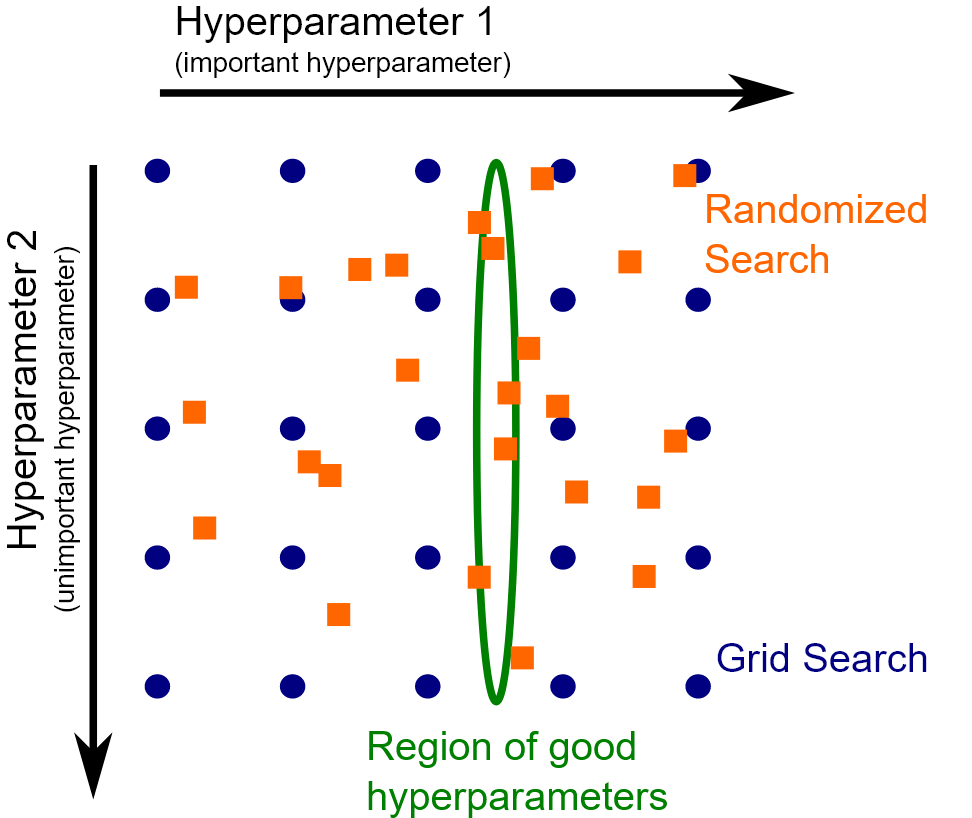

The **RandomizedSearchCV** class allows for such stochastic search. 

It is used similarly to the GridSearchCV but the sampling distributions need to be specified instead of the parameter values. 

For instance, we will draw candidates using a log-uniform distribution because the parameters we are interested in take positive values with a natural log scaling (.1 is as close to 1 as 10 is).

We will optimize 3 other parameters in addition to the ones we optimized in the notebook presenting the GridSearchCV:
- l2_regularization: it corresponds to the strength of the regularization;
- min_samples_leaf: it corresponds to the minimum number of samples required in a leaf;
- max_bins: it corresponds to the maximum number of bins to construct the histograms.

In [7]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


**Now, we can define the randomized search using the different distributions.**

Executing 10 iterations of 5-fold cross-validation for random parametrizations of this model on this dataset can take from 10 seconds to several minutes, depending on the speed of the host computer and the number of available processors.


In [9]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=5, verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 2min 9s
Wall time: 36.8 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              Hi...
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023427419490>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x0000023427C428E0>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x0000023427C42220>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x0000023427BD5790>},
                   verbose=1)

In [10]:
# Then, we can compute the accuracy score on the test set.

accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.88


In [11]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 0.000106991755130965,
 'classifier__learning_rate': 0.8787202215977885,
 'classifier__max_bins': 152,
 'classifier__max_leaf_nodes': 3,
 'classifier__min_samples_leaf': 69}


In [12]:
# We can inspect the results using the attributes cv_results as we did previously.

# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
7,0.000107,0.87872,3,69,152,0.864951,0.002963,1
2,0.013691,0.818333,2,85,126,0.859381,0.002824,2
1,0.000076,1.110173,21,21,137,0.858917,0.004531,3
5,403.886746,0.80369,24,2,69,0.857170,0.002118,4
8,37.238954,0.188284,46,58,53,0.855969,0.002035,5
9,0.003088,0.548582,10,68,18,0.853731,0.002270,6
0,30.346703,0.070226,5,1,54,0.853703,0.002603,7
4,744.170109,0.887002,9,4,13,0.845486,0.003039,8
6,0.000047,1.643205,21,10,120,0.825722,0.007022,9
3,5.280156,5.119772,17,3,165,0.768174,0.018350,10


Keep in mind that tuning is limited by the number of different combinations of parameters that are scored by the randomized search. In fact, there might be other sets of parameters leading to similar or better generalization performances but that were not tested in the search. In practice, a randomized hyperparameter search is usually run with a large number of iterations. In order to avoid the computation cost and still make a decent analysis, we load the results obtained from a similar search with 500 iterations.

In [13]:
# model_random_search = RandomizedSearchCV(
#     model, param_distributions=param_distributions, n_iter=500,
#     n_jobs=2, cv=5)
# model_random_search.fit(data_train, target_train)
# cv_results =  pd.DataFrame(model_random_search.cv_results_)
# cv_results.to_csv("../figures/randomized_search_results.csv")

In [15]:
#cv_results = pd.read_csv("../../figures/randomized_search_results.csv", index_col=0)

#(cv_results[column_results].rename(
#    shorten_param, axis=1).sort_values("mean_test_score", ascending=False))